In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle

%matplotlib inline

font = 'Arial'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font
plt.rcParams['mathtext.bf'] = font
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

linewidth = 2.5

In [2]:
def extract_score(file_name, seed_list, test_flag, ver2_flag=1):
    total_score, total_len = None, 0
    total_sample = None
    for seed in seed_list:
        if test_flag == 0:
            df = pd.read_csv(file_name + str(seed) + '/train.csv')
        else:
            df = pd.read_csv(file_name + str(seed) + '/eval.csv')
        if total_score is None:
            if ver2_flag == 1:
                total_score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                total_score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                total_score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 4:
                total_score = df['episode_reward'].values
            elif ver2_flag == 5:
                total_score = df['true_episode_success'].values * 100
            else:
                total_score = df['success_rate'].values
            total_len = len(total_score)
            total_score = total_score.reshape(1, -1)
            total_sample = df['step'].values
            total_sample = total_sample.reshape(1, -1)
        else:
            if ver2_flag == 1:
                score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 4:
                score = df['episode_reward'].values
            elif ver2_flag == 5:
                score = df['true_episode_success'].values * 100
            else:
                score = df['success_rate'].values
            temp_len = len(score)
            score = score.reshape(1, -1)
            sample = df['step'].values
            sample = sample.reshape(1, -1)
            
            if temp_len < total_len:
                total_len = temp_len
                total_sample = sample
                
            total_score = np.concatenate(
                (total_score[:, :total_len], 
                 score[0][:total_len].reshape(1, -1)), 
                axis=0)
            
    total_avg = np.average(total_score, axis=0)
    total_std = np.std(total_score, axis=0)
    return total_avg, total_std, total_sample, total_score

In [3]:
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [4]:
def draw_figures(x_val, avg_val, std_val, ax, color, label, dash=False):
    if dash:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25, linestyle=':')
        
    else:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25)
    
    ax.fill_between(x_val, 
                    avg_val - std_val, 
                    avg_val + std_val, 
                    facecolor=color[:4], 
                    edgecolor=(0, 0, 0, 0))
    return ax

In [22]:
red_color = (247/255, 112/255, 136/255, 0.15)
blue_color = (128/255, 150/255, 244/255, 0.15)
dark_blue_color = (0/255, 83/255, 214/255, 0.15)
green_color = (51/255, 176/255, 122/255, 0.15)
purple_color = (204/255, 122/255, 244/255, 0.15)
orange_color = (255/255, 161/255, 0/255, 0.15)
black_color = (0/255, 0/255, 0/255, 0.15)
berkeley_blue_color = (0/255,50/255,98/255, 0.15)
cali_gold_color = (253/255,181/255,21/255, 0.15)
real_blue_color = (0/255, 0/255, 244/255, 0.15)
real_green_color = (0/255, 255/255, 0/255, 0.15)
real_red_color = (255/255, 0/255, 0/255, 0.15)
new_green_color = (92/255, 148/255, 13/255, 0.15) 
new_purple_color = (134/255, 46/255, 156/255, 0.15) 
new_yellow_color = (255/255, 224/255, 102/255, 0.15) 
deeppink_color = (255/255, 20/255, 147/255, 0.15)

color_list =[red_color, blue_color, dark_blue_color,
             green_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color, red_color, blue_color, dark_blue_color,
             green_color, purple_color, new_purple_color, new_yellow_color, red_color, blue_color, dark_blue_color,
             green_color, purple_color]
color_max = len(color_list)

# Setup

In [6]:
domain_name = 'metaworld' # 'metaworld'
task_name = 'sweep-into-v2'  # 'pick-place-v2' 'hammer-v2' 
env_name = domain_name + '_' + task_name

arch = 'H256_L3'
sac_lr = 0.0003

# Normal - PPO

In [7]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PPO/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

# best
lr_list = [0.00003]
nstep_list = [250]
nenv_list = [32]
batch_list = [256]

ppo_normal_avg, ppo_normal_std, ppo_normal_step = dict(), dict(), dict()
s_ppo_normal_avg, s_ppo_normal_std, s_ppo_normal_step = dict(), dict(), dict()

ppo_normal_name_list = []

for lr in lr_list:
    for nstep in nstep_list:
        for batch in batch_list:
            for nenv in nenv_list:
                key = 'ppo: ns' + str(nstep) + '_lr' + str(lr) 
                key += '_ne' + str(nenv) + '_b' + str(batch)
                ppo_normal_name_list.append(key)
                file_name = root_dir + 'normalized_' + env_name

                file_name += '/lr_' + str(lr) 
                file_name += '_batch_' + str(batch)
                file_name += '_nenvs_' + str(nenv)
                file_name += '_nsteps_'+ str(nstep)
                file_name += '_ent_0.0_hidden_256'
                file_name += '_sde_1_sdefreq_4_gae_0.92_clip_0.4_nepochs_20_seed_'
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
                ppo_normal_avg[key] = total_avg
                ppo_normal_std[key] = total_std
                ppo_normal_step[key] = total_sample
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
                s_ppo_normal_avg[key] = total_avg
                s_ppo_normal_std[key] = total_std
                s_ppo_normal_step[key] = total_sample

In [8]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PPO_Unsuper/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

# best
lr_list = [0.00003]
nstep_list = [250]
nenv_list = [32]
batch_list = [256]

ppo_un_normal_avg, ppo_un_normal_std, ppo_un_normal_step = dict(), dict(), dict()
s_ppo_un_normal_avg, s_ppo_un_normal_std, s_ppo_un_normal_step = dict(), dict(), dict()

ppo_un_normal_name_list = []

for lr in lr_list:
    for nstep in nstep_list:
        for batch in batch_list:
            for nenv in nenv_list:
                key = 'ppo un: ns' + str(nstep) + '_lr' + str(lr) 
                key += '_ne' + str(nenv) + '_b' + str(batch)
                ppo_un_normal_name_list.append(key)
                file_name = root_dir + 'normalized_' + env_name

                file_name += '/lr_' + str(lr) 
                file_name += '_batch_' + str(batch)
                file_name += '_nenvs_' + str(nenv)
                file_name += '_nsteps_'+ str(nstep)
                file_name += '_ent_0.0_hidden_256'
                file_name += '_sde_1_sdefreq_4_gae_0.92_clip_0.4_nepochs_20_unsuper_32000_update_50_seed_'
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
                ppo_un_normal_avg[key] = total_avg
                ppo_un_normal_std[key] = total_std
                ppo_un_normal_step[key] = total_sample
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
                s_ppo_un_normal_avg[key] = total_avg
                s_ppo_un_normal_std[key] = total_std
                s_ppo_un_normal_step[key] = total_sample

# Preference PPO

In [9]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PrefPPO/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

un_pre_ppo_avg, un_pre_ppo_std, un_pre_ppo_step = dict(), dict(), dict()
s_un_pre_ppo_avg, s_un_pre_ppo_std, s_un_pre_ppo_step = dict(), dict(), dict()
un_pre_ppo_name_list = []

un_pre_ppo_tot, s_un_pre_ppo_tot = dict(), dict()


lr= 0.0003
feed_type = 1

fedd_teacher_option_list = [
#     (32000, 25, 20000, 1000, 32, 'o'),
#     (32000, 50, 20000, 1000, 32, 'o'),
#     (32000, 25, 20000, 1000, 64, 'o'),
#     (32000, 50, 20000, 1000, 64, 'o'),
#     (32000, 25, 20000, 500, 32, 'o'),
#     (32000, 50, 20000, 500, 32, 'o'),
#     (32000, 25, 20000, 500, 64, 'o'),
#     (32000, 50, 20000, 500, 64, 'o'),
#     (64000, 25, 20000, 1000, 32, 'o'),
#     (64000, 50, 20000, 1000, 32, 'o'),
#     (64000, 25, 20000, 1000, 64, 'o'),
#     (64000, 50, 20000, 1000, 64, 'o'),
#     (64000, 25, 20000, 500, 32, 'o'),
#     (64000, 50, 20000, 500, 32, 'o'),
#     (64000, 25, 20000, 500, 64, 'o'),
    (64000, 50, 20000, 500, 64, 'o'), # best
    
#     (32000, 25, 10000, 250, 32, 'o'),
#     (32000, 50, 10000, 250, 32, 'o'),
#     (32000, 25, 10000, 250, 64, 'o'),
#     (32000, 50, 10000, 250, 64, 'o'),
#     (32000, 25, 10000, 500, 32, 'o'),
#     (32000, 50, 10000, 500, 32, 'o'),
#     (32000, 25, 10000, 500, 64, 'o'),
    (32000, 50, 10000, 500, 64, 'o'), # best
#     (64000, 25, 10000, 250, 32, 'o'),
#     (64000, 50, 10000, 250, 32, 'o'),
#     (64000, 25, 10000, 250, 64, 'o'),
#     (64000, 50, 10000, 250, 64, 'o'),
#     (64000, 25, 10000, 500, 32, 'o'),
#     (64000, 50, 10000, 500, 32, 'o'),
#     (64000, 25, 10000, 500, 64, 'o'),
#     (64000, 50, 10000, 500, 64, 'o'),

#     (32000, 25, 20000, 1000, 32, 'mi'),
#     (32000, 50, 20000, 1000, 32, 'mi'),
#     (32000, 25, 20000, 1000, 64, 'mi'),
#     (32000, 50, 20000, 1000, 64, 'mi'),
#     (32000, 25, 20000, 500, 32, 'mi'),
#     (32000, 50, 20000, 500, 32, 'mi'),
#     (32000, 25, 20000, 500, 64, 'mi'),
#     (32000, 50, 20000, 500, 64, 'mi'),
#     (64000, 25, 20000, 1000, 32, 'mi'),
#     (64000, 50, 20000, 1000, 32, 'mi'),
#     (64000, 25, 20000, 1000, 64, 'mi'),
    (64000, 50, 20000, 1000, 64, 'mi'), # best
#     (64000, 25, 20000, 500, 32, 'mi'),
#     (64000, 50, 20000, 500, 32, 'mi'),
#     (64000, 25, 20000, 500, 64, 'mi'),
#     (64000, 50, 20000, 500, 64, 'mi'),
    
#     (32000, 25, 10000, 250, 32, 'mi'),
#     (32000, 50, 10000, 250, 32, 'mi'),
#     (32000, 25, 10000, 250, 64, 'mi'),
    (32000, 50, 10000, 250, 64, 'mi'), # best
#     (32000, 25, 10000, 500, 32, 'mi'),
#     (32000, 50, 10000, 500, 32, 'mi'),
#     (32000, 25, 10000, 500, 64, 'mi'),
#     (32000, 50, 10000, 500, 64, 'mi'),
#     (64000, 25, 10000, 250, 32, 'mi'),
#     (64000, 50, 10000, 250, 32, 'mi'),
#     (64000, 25, 10000, 250, 64, 'mi'),
#     (64000, 50, 10000, 250, 64, 'mi'),
#     (64000, 25, 10000, 500, 32, 'mi'),
#     (64000, 50, 10000, 500, 32, 'mi'),
#     (64000, 25, 10000, 500, 64, 'mi'),
#     (64000, 50, 10000, 500, 64, 'mi'),

#     (32000, 25, 20000, 1000, 32, 'n'),
#     (32000, 50, 20000, 1000, 32, 'n'),
#     (32000, 25, 20000, 1000, 64, 'n'),
#     (32000, 50, 20000, 1000, 64, 'n'),
#     (32000, 25, 20000, 500, 32, 'n'),
#     (32000, 50, 20000, 500, 32, 'n'),
#     (32000, 25, 20000, 500, 64, 'n'),
    (32000, 50, 20000, 500, 64, 'n'), # best
#     (64000, 25, 20000, 1000, 32, 'n'),
#     (64000, 50, 20000, 1000, 32, 'n'),
#     (64000, 25, 20000, 1000, 64, 'n'),
#     (64000, 50, 20000, 1000, 64, 'n'),
#     (64000, 25, 20000, 500, 32, 'n'),
#     (64000, 50, 20000, 500, 32, 'n'),
#     (64000, 25, 20000, 500, 64, 'n'),
#     (64000, 50, 20000, 500, 64, 'n'),
    
#     (32000, 25, 10000, 250, 32, 'n'),
#     (32000, 50, 10000, 250, 32, 'n'),
#     (32000, 25, 10000, 250, 64, 'n'),
#     (32000, 50, 10000, 250, 64, 'n'),
#     (32000, 25, 10000, 500, 32, 'n'),
#     (32000, 50, 10000, 500, 32, 'n'),
#     (32000, 25, 10000, 500, 64, 'n'),
    (32000, 50, 10000, 500, 64, 'n'), # best
#     (64000, 25, 10000, 250, 32, 'n'),
#     (64000, 50, 10000, 250, 32, 'n'),
#     (64000, 25, 10000, 250, 64, 'n'),
#     (64000, 50, 10000, 250, 64, 'n'),
#     (64000, 25, 10000, 500, 32, 'n'),
#     (64000, 50, 10000, 500, 32, 'n'),
#     (64000, 25, 10000, 500, 64, 'n'),
#     (64000, 50, 10000, 500, 64, 'n'),
    
#     (32000, 25, 20000, 1000, 32, 'my'),
#     (32000, 50, 20000, 1000, 32, 'my'),
#     (32000, 25, 20000, 1000, 64, 'my'),
#     (32000, 50, 20000, 1000, 64, 'my'),
#     (32000, 25, 20000, 500, 32, 'my'),
#     (32000, 50, 20000, 500, 32, 'my'),
    (32000, 25, 20000, 500, 64, 'my'),
#     (32000, 50, 20000, 500, 64, 'my'),
#     (64000, 25, 20000, 1000, 32, 'my'),
#     (64000, 50, 20000, 1000, 32, 'my'),
#     (64000, 25, 20000, 1000, 64, 'my'),
#     (64000, 50, 20000, 1000, 64, 'my'),
#     (64000, 25, 20000, 500, 32, 'my'),
#     (64000, 50, 20000, 500, 32, 'my'),
#     (64000, 25, 20000, 500, 64, 'my'),
#     (64000, 50, 20000, 500, 64, 'my'),

#     (32000, 25, 10000, 250, 32, 'my'),
#     (32000, 50, 10000, 250, 32, 'my'),
#     (32000, 25, 10000, 250, 64, 'my'),
#     (32000, 50, 10000, 250, 64, 'my'), 
#     (32000, 25, 10000, 500, 32, 'my'),
#     (32000, 50, 10000, 500, 32, 'my'),
    (32000, 25, 10000, 500, 64, 'my'), # best
#     (32000, 50, 10000, 500, 64, 'my'),
#     (64000, 25, 10000, 250, 32, 'my'),
#     (64000, 50, 10000, 250, 32, 'my'),
#     (64000, 25, 10000, 250, 64, 'my'),
#     (64000, 50, 10000, 250, 64, 'my'),
#     (64000, 25, 10000, 500, 32, 'my'),
#     (64000, 50, 10000, 500, 32, 'my'),
#     (64000, 25, 10000, 500, 64, 'my'),
#     (64000, 50, 10000, 500, 64, 'my'),
    
    
#     (32000, 25, 20000, 1000, 32, 'e'),
#     (32000, 50, 20000, 1000, 32, 'e'),
#     (32000, 25, 20000, 1000, 64, 'e'),
#     (32000, 50, 20000, 1000, 64, 'e'),
#     (32000, 25, 20000, 500, 32, 'e'),
#     (32000, 50, 20000, 500, 32, 'e'),
    (32000, 25, 20000, 500, 64, 'e'),
#     (32000, 50, 20000, 500, 64, 'e'),
#     (64000, 25, 20000, 1000, 32, 'e'),
#     (64000, 50, 20000, 1000, 32, 'e'),
#     (64000, 25, 20000, 1000, 64, 'e'),
#     (64000, 50, 20000, 1000, 64, 'e'),
#     (64000, 25, 20000, 500, 32, 'e'),
#     (64000, 50, 20000, 500, 32, 'e'),
#     (64000, 25, 20000, 500, 64, 'e'),
#     (64000, 50, 20000, 500, 64, 'e'),

#     (32000, 25, 10000, 250, 32, 'e'),
#     (32000, 50, 10000, 250, 32, 'e'),
#     (32000, 25, 10000, 250, 64, 'e'),
    (32000, 50, 10000, 250, 64, 'e'), 
#     (32000, 25, 10000, 500, 32, 'e'),
#     (32000, 50, 10000, 500, 32, 'e'),
#     (32000, 25, 10000, 500, 64, 'e'), 
#     (32000, 50, 10000, 500, 64, 'e'),
#     (64000, 25, 10000, 250, 32, 'e'),
#     (64000, 50, 10000, 250, 32, 'e'),
#     (64000, 25, 10000, 250, 64, 'e'),
#     (64000, 50, 10000, 250, 64, 'e'),
#     (64000, 25, 10000, 500, 32, 'e'),
#     (64000, 50, 10000, 500, 32, 'e'),
#     (64000, 25, 10000, 500, 64, 'e'),
#     (64000, 50, 10000, 500, 64, 'e'),
    
#     (32000, 25, 20000, 1000, 32, 's'),
#     (32000, 50, 20000, 1000, 32, 's'),
#     (32000, 25, 20000, 1000, 64, 's'),
#     (32000, 50, 20000, 1000, 64, 's'),
#     (32000, 25, 20000, 500, 32, 's'),
#     (32000, 50, 20000, 500, 32, 's'),
#     (32000, 25, 20000, 500, 64, 's'),
    (32000, 50, 20000, 500, 64, 's'),
#     (64000, 25, 20000, 1000, 32, 's'),
#     (64000, 50, 20000, 1000, 32, 's'),
#     (64000, 25, 20000, 1000, 64, 's'),
#     (64000, 50, 20000, 1000, 64, 's'),
#     (64000, 25, 20000, 500, 32, 's'),
#     (64000, 50, 20000, 500, 32, 's'),
#     (64000, 25, 20000, 500, 64, 's'),
#     (64000, 50, 20000, 500, 64, 's'),

#     (32000, 25, 10000, 250, 32, 's'),
#     (32000, 50, 10000, 250, 32, 's'),
#     (32000, 25, 10000, 250, 64, 's'),
#     (32000, 50, 10000, 250, 64, 's'), 
#     (32000, 25, 10000, 500, 32, 's'),
#     (32000, 50, 10000, 500, 32, 's'),
#     (32000, 25, 10000, 500, 64, 's'), 
#     (32000, 50, 10000, 500, 64, 's'),
#     (64000, 25, 10000, 250, 32, 's'),
#     (64000, 50, 10000, 250, 32, 's'),
#     (64000, 25, 10000, 250, 64, 's'),
#     (64000, 50, 10000, 250, 64, 's'),
#     (64000, 25, 10000, 500, 32, 's'),
#     (64000, 50, 10000, 500, 32, 's'),
#     (64000, 25, 10000, 500, 64, 's'),
    (64000, 50, 10000, 500, 64, 's'),
]

for interact, seg_size, max_feed, rbatch, nenvs, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_1.0_1.0_0.0_0.0_0.0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_-1.0_0.9_0.0_0.0_0.0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_-1.0_1.0_0.1_0.0_0.0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.1_0.0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.0_0.0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.0_0.1'

    key = 'PrePPO [' + str(feed_type) + '] (max='+ str(max_feed) + ', seg=' + str(seg_size)
    key += ', int=' + str(interact) + ', rb=' + str(rbatch) + ', nenv=' + str(nenvs)
    key += ', te=' + str(teacher_index) + ')'
    un_pre_ppo_name_list.append(key)
    
#     print('--')
#     print(interact)
#     print(seg_size)
#     print(teacher_index)
#     print(nenvs)
#     print(max_feed)
#     print(rbatch)
    file_name = root_dir + 'normalized_' + env_name
    file_name += teacher_dir
    file_name += '/lr_' + str(lr) + '_reward_lr0.0003_seg' + str(seg_size) + '_acttanh'
    file_name += '_inter' + str(interact) + '_type' + str(feed_type)
    file_name += '_large10_rebatch' + str(rbatch)
    file_name += '_reupdate50_batch_256'
    file_name += '_nenvs_' + str(nenvs)
    file_name += '_nsteps_250_ent_0.0_hidden_256_sde_1_sdefreq_4'
    file_name += '_gae_0.92_clip_0.4_nepochs_20_maxfeed_'+str(max_feed)
    file_name += '_unsuper_32000_update_50'
    file_name += '_seed_'
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    un_pre_ppo_avg[key] = total_avg
    un_pre_ppo_std[key] = total_std
    un_pre_ppo_step[key] = total_sample
    un_pre_ppo_tot[key] = total_score
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
    s_un_pre_ppo_avg[key] = total_avg
    s_un_pre_ppo_std[key] = total_std
    s_un_pre_ppo_step[key] = total_sample
    s_un_pre_ppo_tot[key] = total_score

# PPO PLOT

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


mean: 887.5346569743749
std: 284.7876826681262
mean: 37.5
std: 10.916867804177462
mean: 1140.94901431125
std: 346.21419792287037
mean: 46.875
std: 11.791902479298304
mean: 642.9458056746876
std: 417.588507151561
mean: 28.5625
std: 15.615195235311543
mean: 527.892715379375
std: 263.39674441960057
mean: 23.875
std: 14.39793936608566


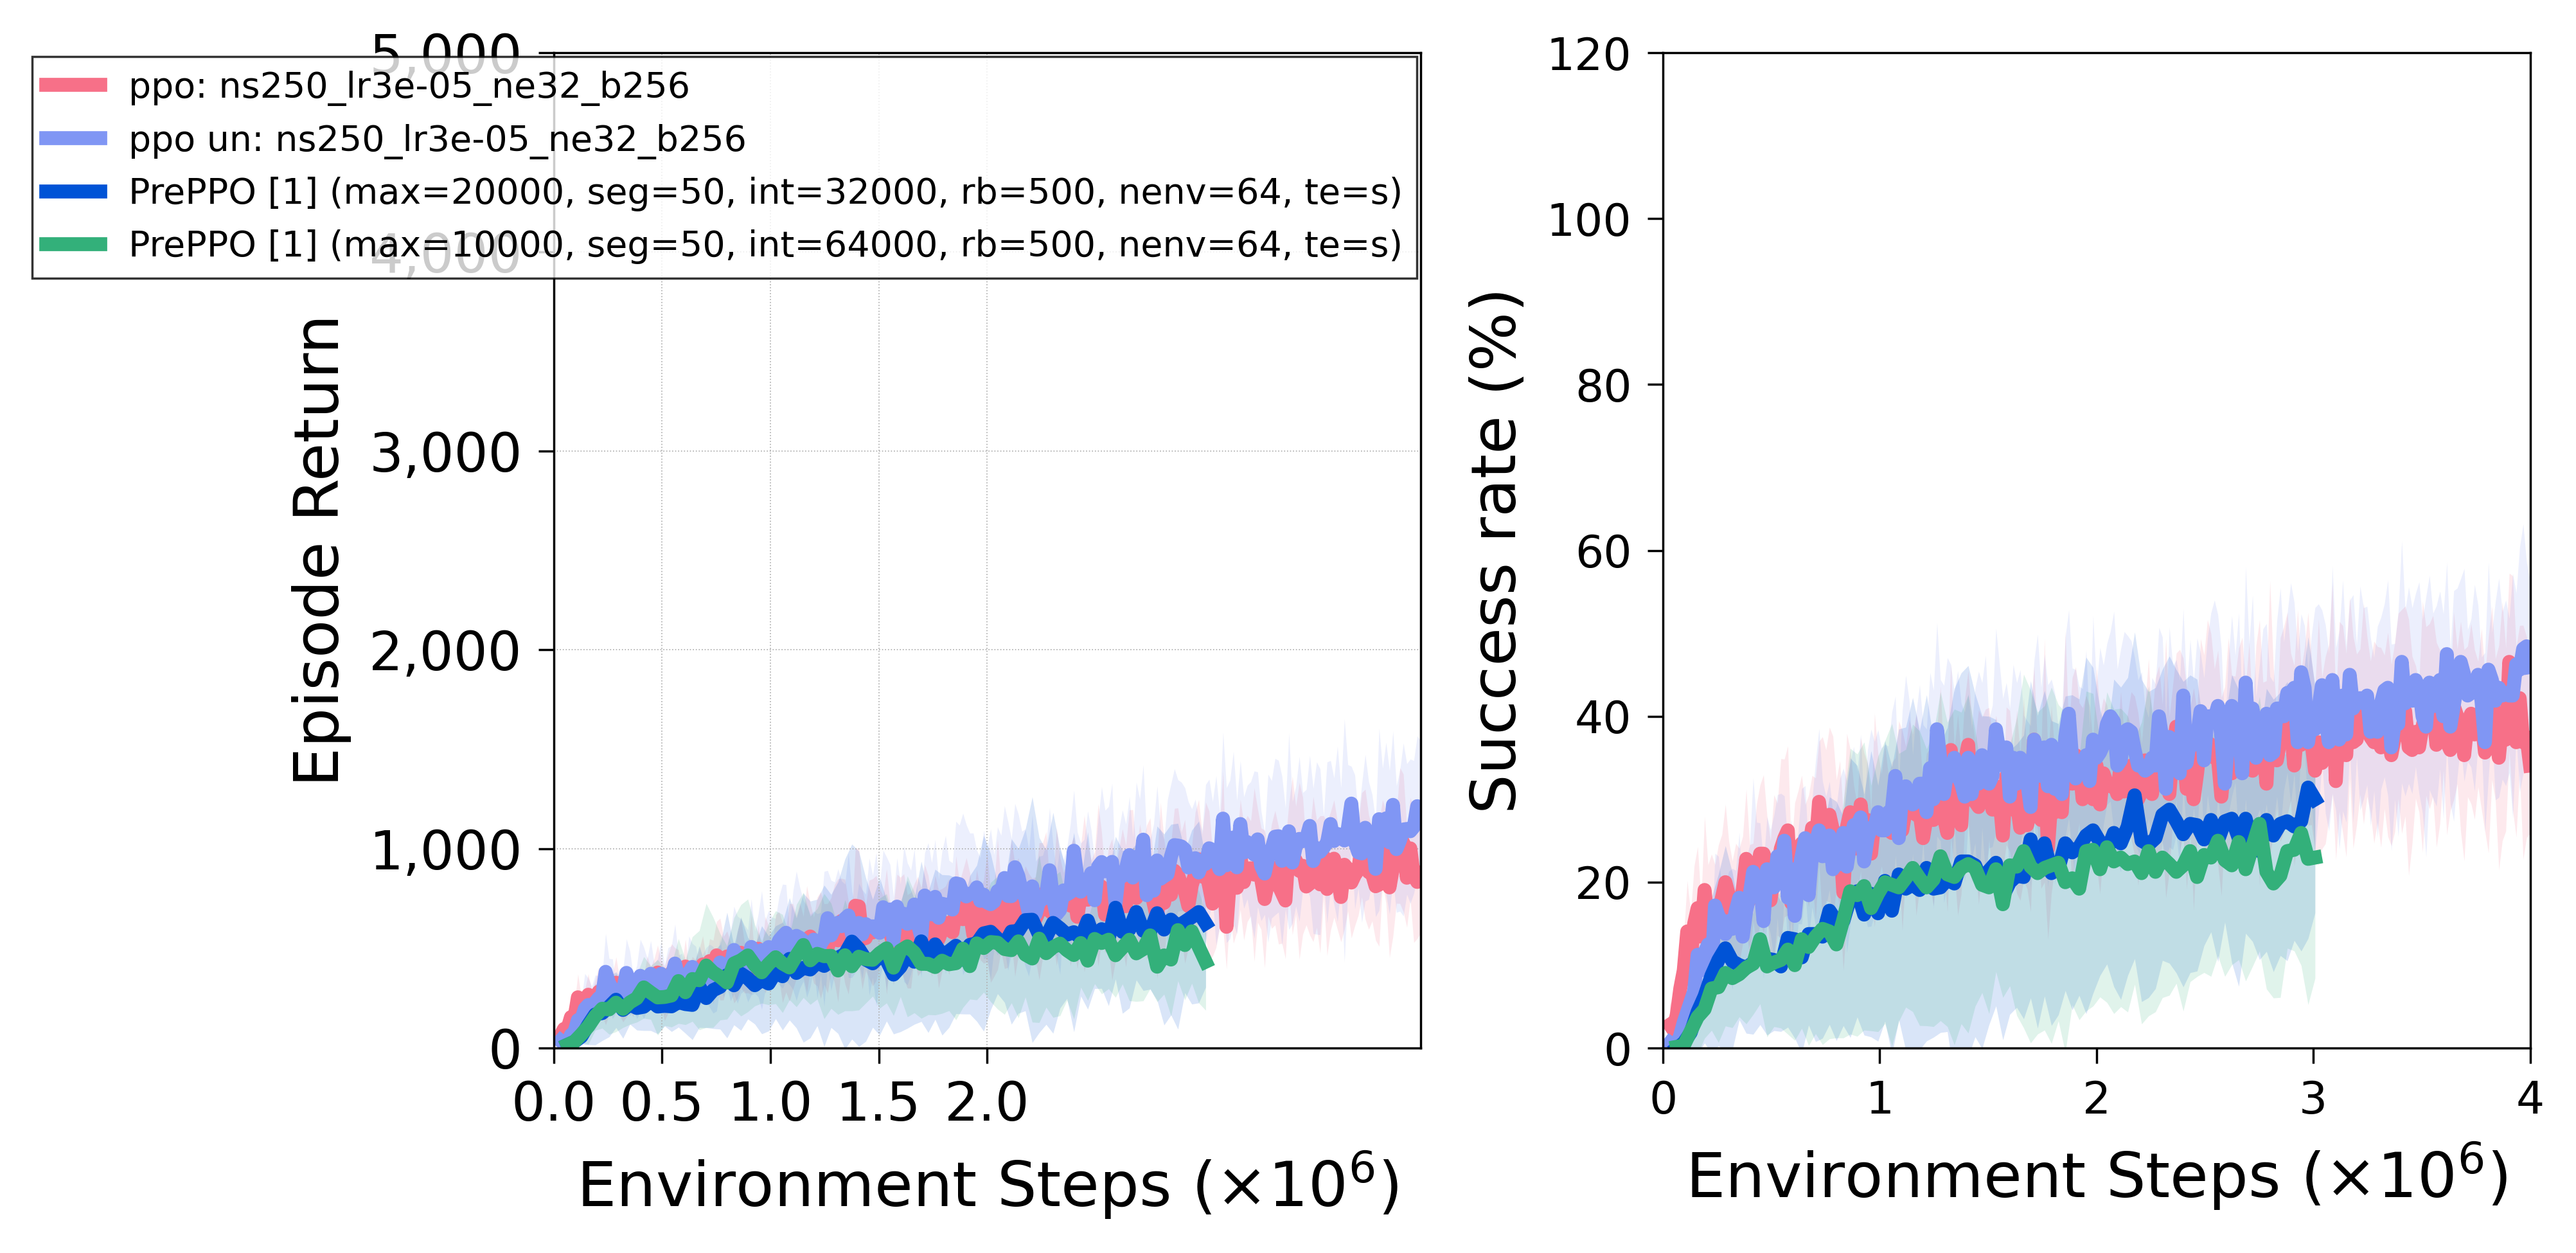

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=500)

base = 1000000

ppo_converge = -5
count = 0
teacher_flag = 'te=s'

for name in ppo_normal_name_list:            
    label = name
    score = ppo_normal_avg[name]
    std = ppo_normal_std[name]
    steps = ppo_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    label = name
    score = s_ppo_normal_avg[name]
    std = s_ppo_normal_std[name]
    steps = s_ppo_normal_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    count += 1
    
for name in ppo_un_normal_name_list:            
    label = name
    score = ppo_un_normal_avg[name]
    std = ppo_un_normal_std[name]
    steps = ppo_un_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    label = name
    score = s_ppo_un_normal_avg[name]
    std = s_ppo_un_normal_std[name]
    steps = s_ppo_un_normal_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    count += 1
    
for name in un_pre_ppo_name_list :            
    label = name
    score = un_pre_ppo_avg[name]
    std = un_pre_ppo_std[name]
    steps = un_pre_ppo_step[name].reshape(-1)
    if teacher_flag in label:
        ax[0] = draw_figures(steps/base, score, std, ax[0], 
                          color_list[count], label)
        print('mean: ' + str(np.mean(score[ppo_converge:])))
        print('std: ' + str(np.mean(std[ppo_converge:])))

        label = name
        score = s_un_pre_ppo_avg[name]
        std = s_un_pre_ppo_std[name]
        steps = s_un_pre_ppo_step[name].reshape(-1)
        ax[1] = draw_figures(steps/base, score, std, ax[1], 
                          color_list[count], label)
        print('mean: ' + str(np.mean(score[ppo_converge:])))
        print('std: ' + str(np.mean(std[ppo_converge:])))

        count += 1
    
    
ax[0].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[0].set_ylabel('Episode Return', fontsize=14)
ax[1].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[1].set_ylabel('Success rate (%)', fontsize=14)


ax[0].grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[0].set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax[0].set_xticks([0, 0.5, 1, 1.5, 2])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax[0].get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax[0].xaxis.major.formatter._useMathText = True

ax[0].set_xlim(0, 4)
ax[0].set_ylim(0, 5000)
ax[1].set_xlim(0, 4)
ax[1].set_ylim(0, 120)

leg = ax[0].legend(fancybox=False, fontsize=8, 
                   edgecolor='black', borderaxespad=0.1, handlelength=1.5)
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# Normal - SAC

In [11]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr_list = [0.0003]

sac_normal_avg, sac_normal_std, sac_normal_step = dict(), dict(), dict()
sac_normal_s_avg, sac_normal_s_std, sac_normal_s_step = dict(), dict(), dict()

sac_normal_name_list = []

for lr in lr_list:
    key = 'sac: normal ' + str(lr)
    sac_normal_name_list.append(key)
    file_name = root_dir + env_name + '/H256_L3_B512_tau0.005/'
    file_name += '/sac_sac_lr' + str(lr) + '_temp0.1_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    sac_normal_avg[key] = total_avg
    sac_normal_std[key] = total_std
    sac_normal_step[key] = total_sample
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_normal_s_avg[key] = total_avg
    sac_normal_s_std[key] = total_std
    sac_normal_s_step[key] = total_sample

In [12]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC_UNSUPER/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.0003

sac_un_normal_avg, sac_un_normal_std, sac_un_normal_step = dict(), dict(), dict()
sac_un_normal_s_avg, sac_un_normal_s_std, sac_un_normal_s_step = dict(), dict(), dict()

sac_un_normal_name_list = []

# unsup_list= [(5, 9000), (5, 99000), (16, 99000)]

unsup_list= [(5, 9000)] # best

for topK, unsup in unsup_list:
    key = 'sac: unsup K' + str(topK) + ', un' + str(unsup)
    sac_un_normal_name_list.append(key)
    file_name = root_dir + env_name + '/H256_L3_B512_tau0.005/'
    file_name += '/sac_unsup' + str(unsup)
    file_name += '_topk' + str(topK)
    file_name += '_sac_lr' + str(lr) + '_temp0.1_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    sac_un_normal_avg[key] = total_avg
    sac_un_normal_std[key] = total_std
    sac_un_normal_step[key] = total_sample
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_un_normal_s_avg[key] = total_avg
    sac_un_normal_s_std[key] = total_std
    sac_un_normal_s_step[key] = total_sample

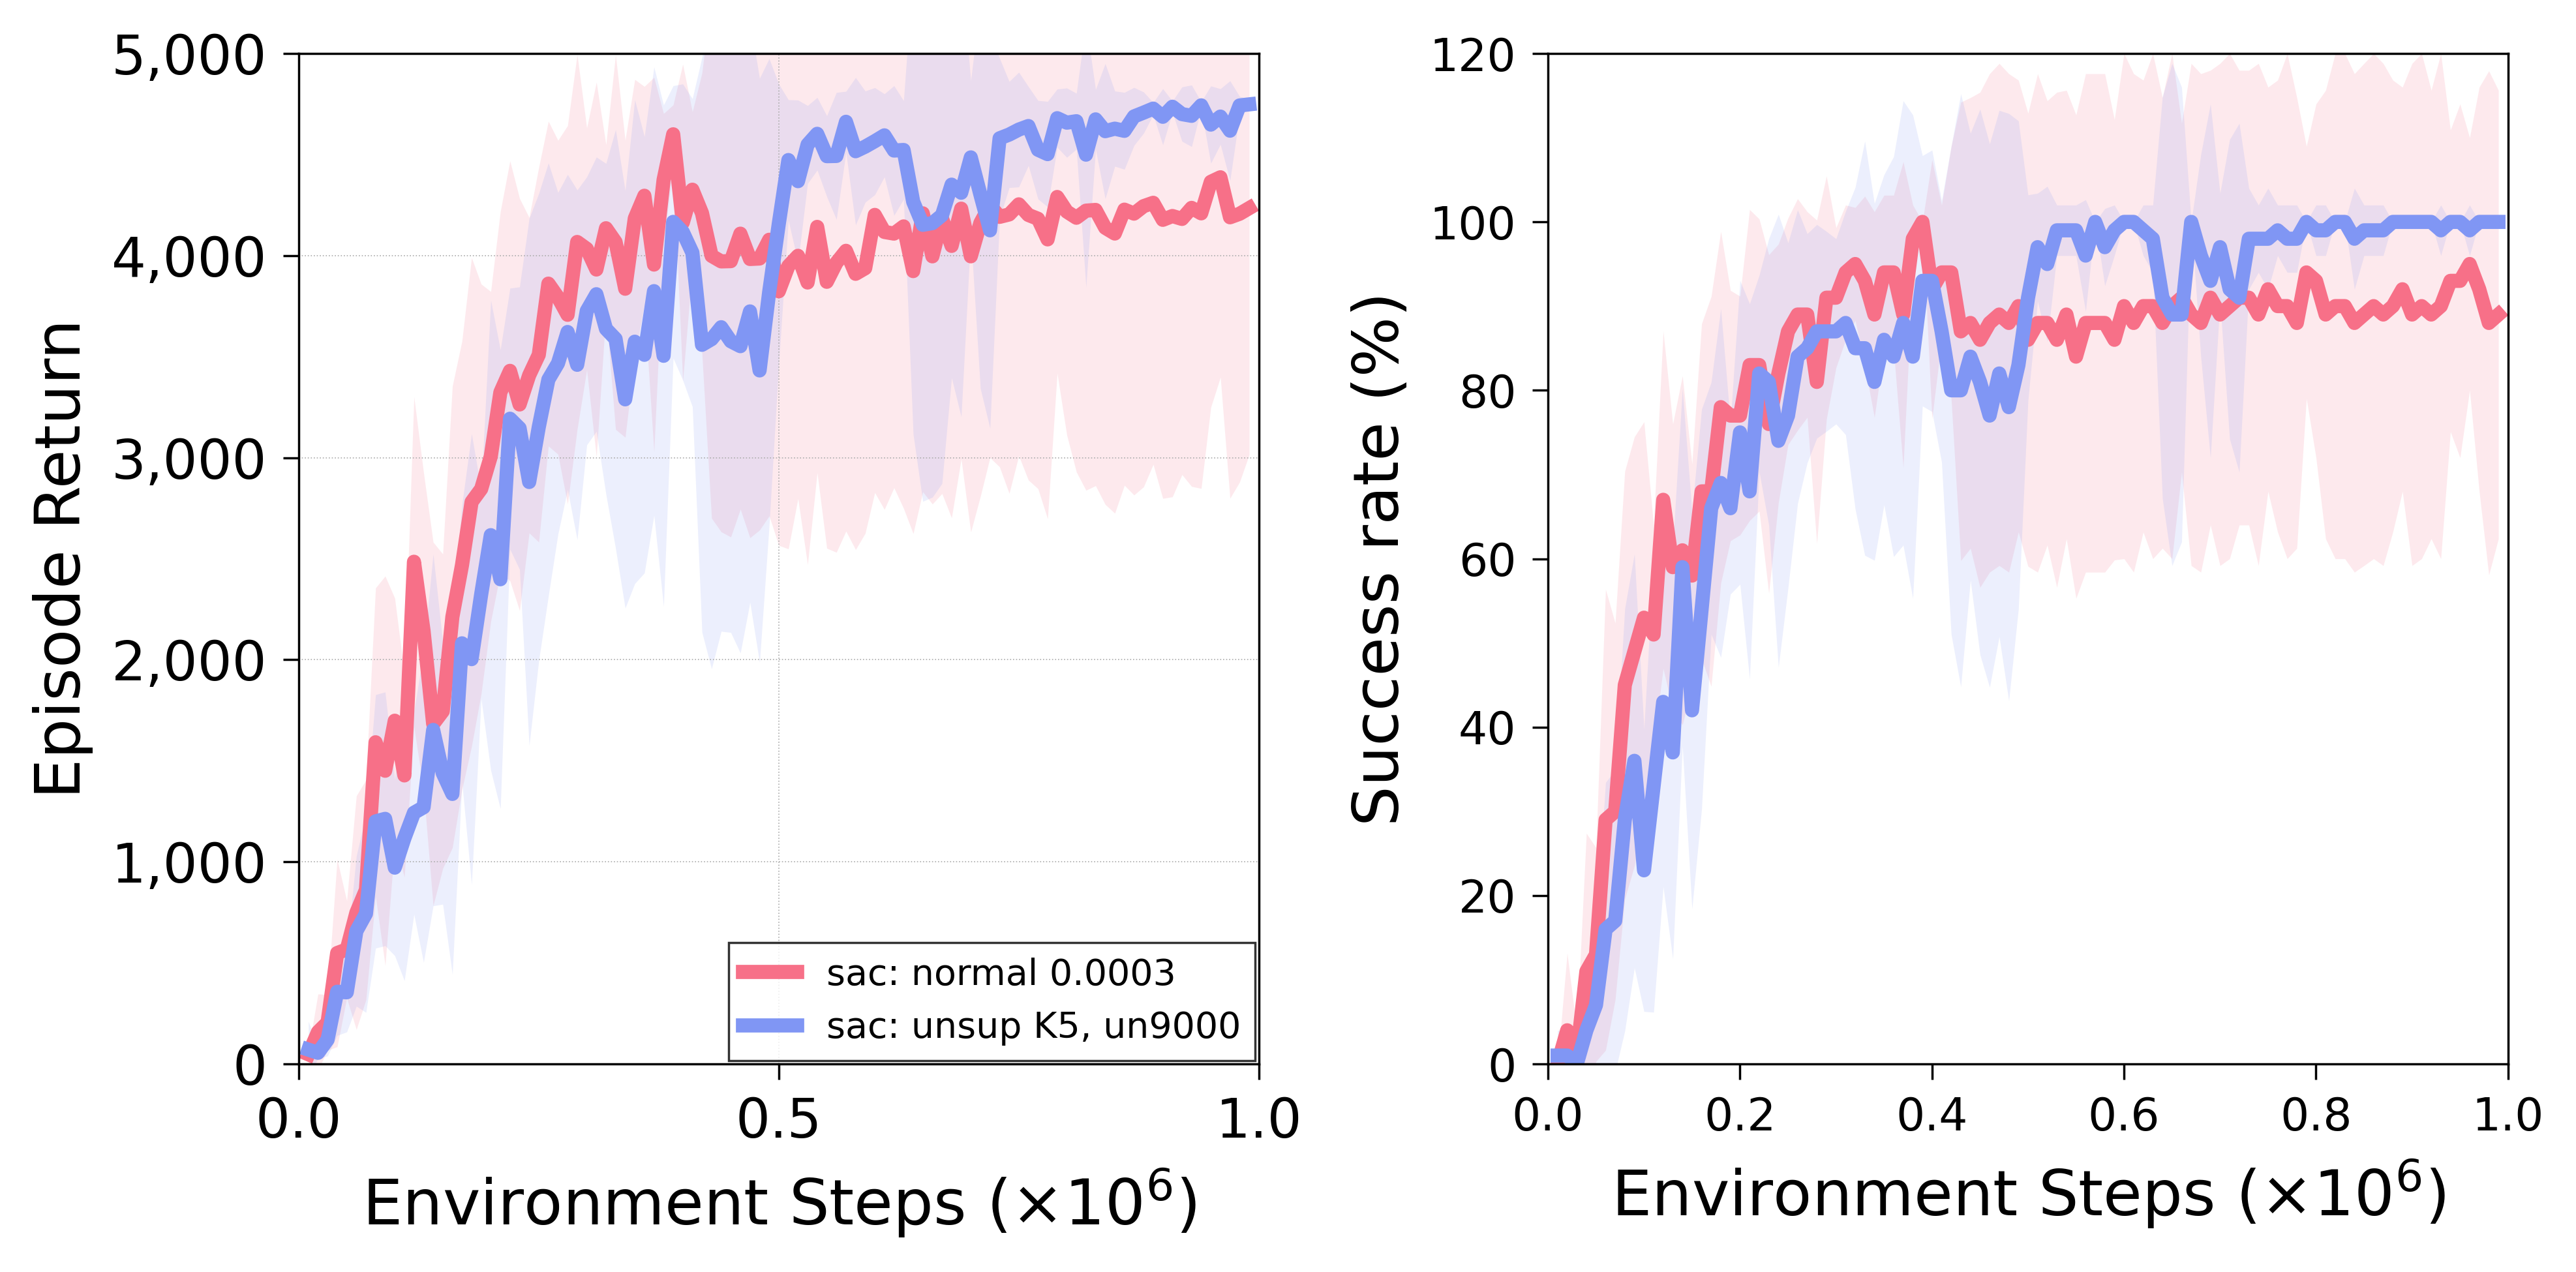

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=500)

base = 1000000

ppo_converge = -5
count = 0
teacher_flag = 'te=s'

for name in sac_normal_name_list:            
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    steps = sac_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)
    
    label = name
    score = sac_normal_s_avg[name]
    std = sac_normal_s_std[name]
    steps = sac_normal_s_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    count += 1
    
for name in sac_un_normal_name_list:            
    label = name
    score = sac_un_normal_avg[name]
    std = sac_un_normal_std[name]
    steps = sac_un_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)

    label = name
    score = sac_un_normal_s_avg[name]
    std = sac_un_normal_s_std[name]
    steps = sac_un_normal_s_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    count += 1

ax[0].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[0].set_ylabel('Episode Return', fontsize=14)
ax[1].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[1].set_ylabel('Success rate (%)', fontsize=14)


ax[0].grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[0].set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax[0].set_xticks([0, 0.5, 1])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax[0].get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax[0].xaxis.major.formatter._useMathText = True

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 5000)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 120)

leg = ax[0].legend(fancybox=False, fontsize=8, 
                   edgecolor='black', borderaxespad=0.1, handlelength=1.5)
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# PEBBLE

In [14]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PEBBLE/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.0003

ori_interact = 5000
ori_num_feed = 100
ori_num_feed_2 = 50

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False

fedd_teacher_option_list = [
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
]

new_pebble_avg, new_pebble_std, new_pebble_step = dict(), dict(), dict()
new_pebble_s_avg, new_pebble_s_std, new_pebble_s_step = dict(), dict(), dict()
new_noise_avg, new_noise_std, new_noise_step = dict(), dict(), dict()

new_pebble_total = dict()
new_pebble_s_total = dict()

new_pebble_name_list = []
teacher_dir = ''
for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_b1_g1_m0_s0_e0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_b-1_g0.9_m0_s0_e0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_b-1_g1_m0.1_s0_e0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_b-1_g1_m0_s0.1_e0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0.1'

    key = 'PEBBLE [' + str(feed_type) + '] (num_feed='+ str(num_feed) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,seg=' + str(segment) + ')'
    new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate10_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
        
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1)
    new_pebble_avg[key] = total_avg
    new_pebble_std[key] = total_std
    new_pebble_step[key] = total_sample
    new_pebble_total[key] = total_score
    
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    new_pebble_s_avg[key] = total_avg
    new_pebble_s_std[key] = total_std
    new_pebble_s_step[key] = total_sample
    new_pebble_s_total[key] = total_score

# Main PLOT

PEBBLE (2K):
Oracle: 0.8526315789473684
Mistake: 0.49473684210526314
Equally preferable: 0.8315789473684211
Skip: 0.9368421052631579
Myopic: 0.7789473684210526
Noisy: 1.0210526315789474
avg: 0.8192982456140351

PEBBLE (1K): 
Oracle: 0.8315789473684211
Mistake: 0.35789473684210527
Equally preferable: 0.8631578947368421
Skip: 0.9368421052631579
Myopic: 0.8947368421052632
Noisy: 0.8105263157894737
avg: 0.7824561403508773

PrePPO + Pre (2K): 
Oracle: 0.7795275590551181
Mistake: 0.3937007874015748
Equally preferable: 0.6141732283464567
Skip: 0.7913385826771654
Myopic: 0.6496062992125984
Noisy: 0.6692913385826772
avg: 0.6496062992125984

PrePPO + Pre (1K): 
Oracle: 0.7598425196850394
Mistake: 0.35826771653543305
Equally preferable: 0.5196850393700787
Skip: 0.6811023622047244
Myopic: 0.6023622047244095
Noisy: 0.6417322834645669
avg: 0.5938320209973753


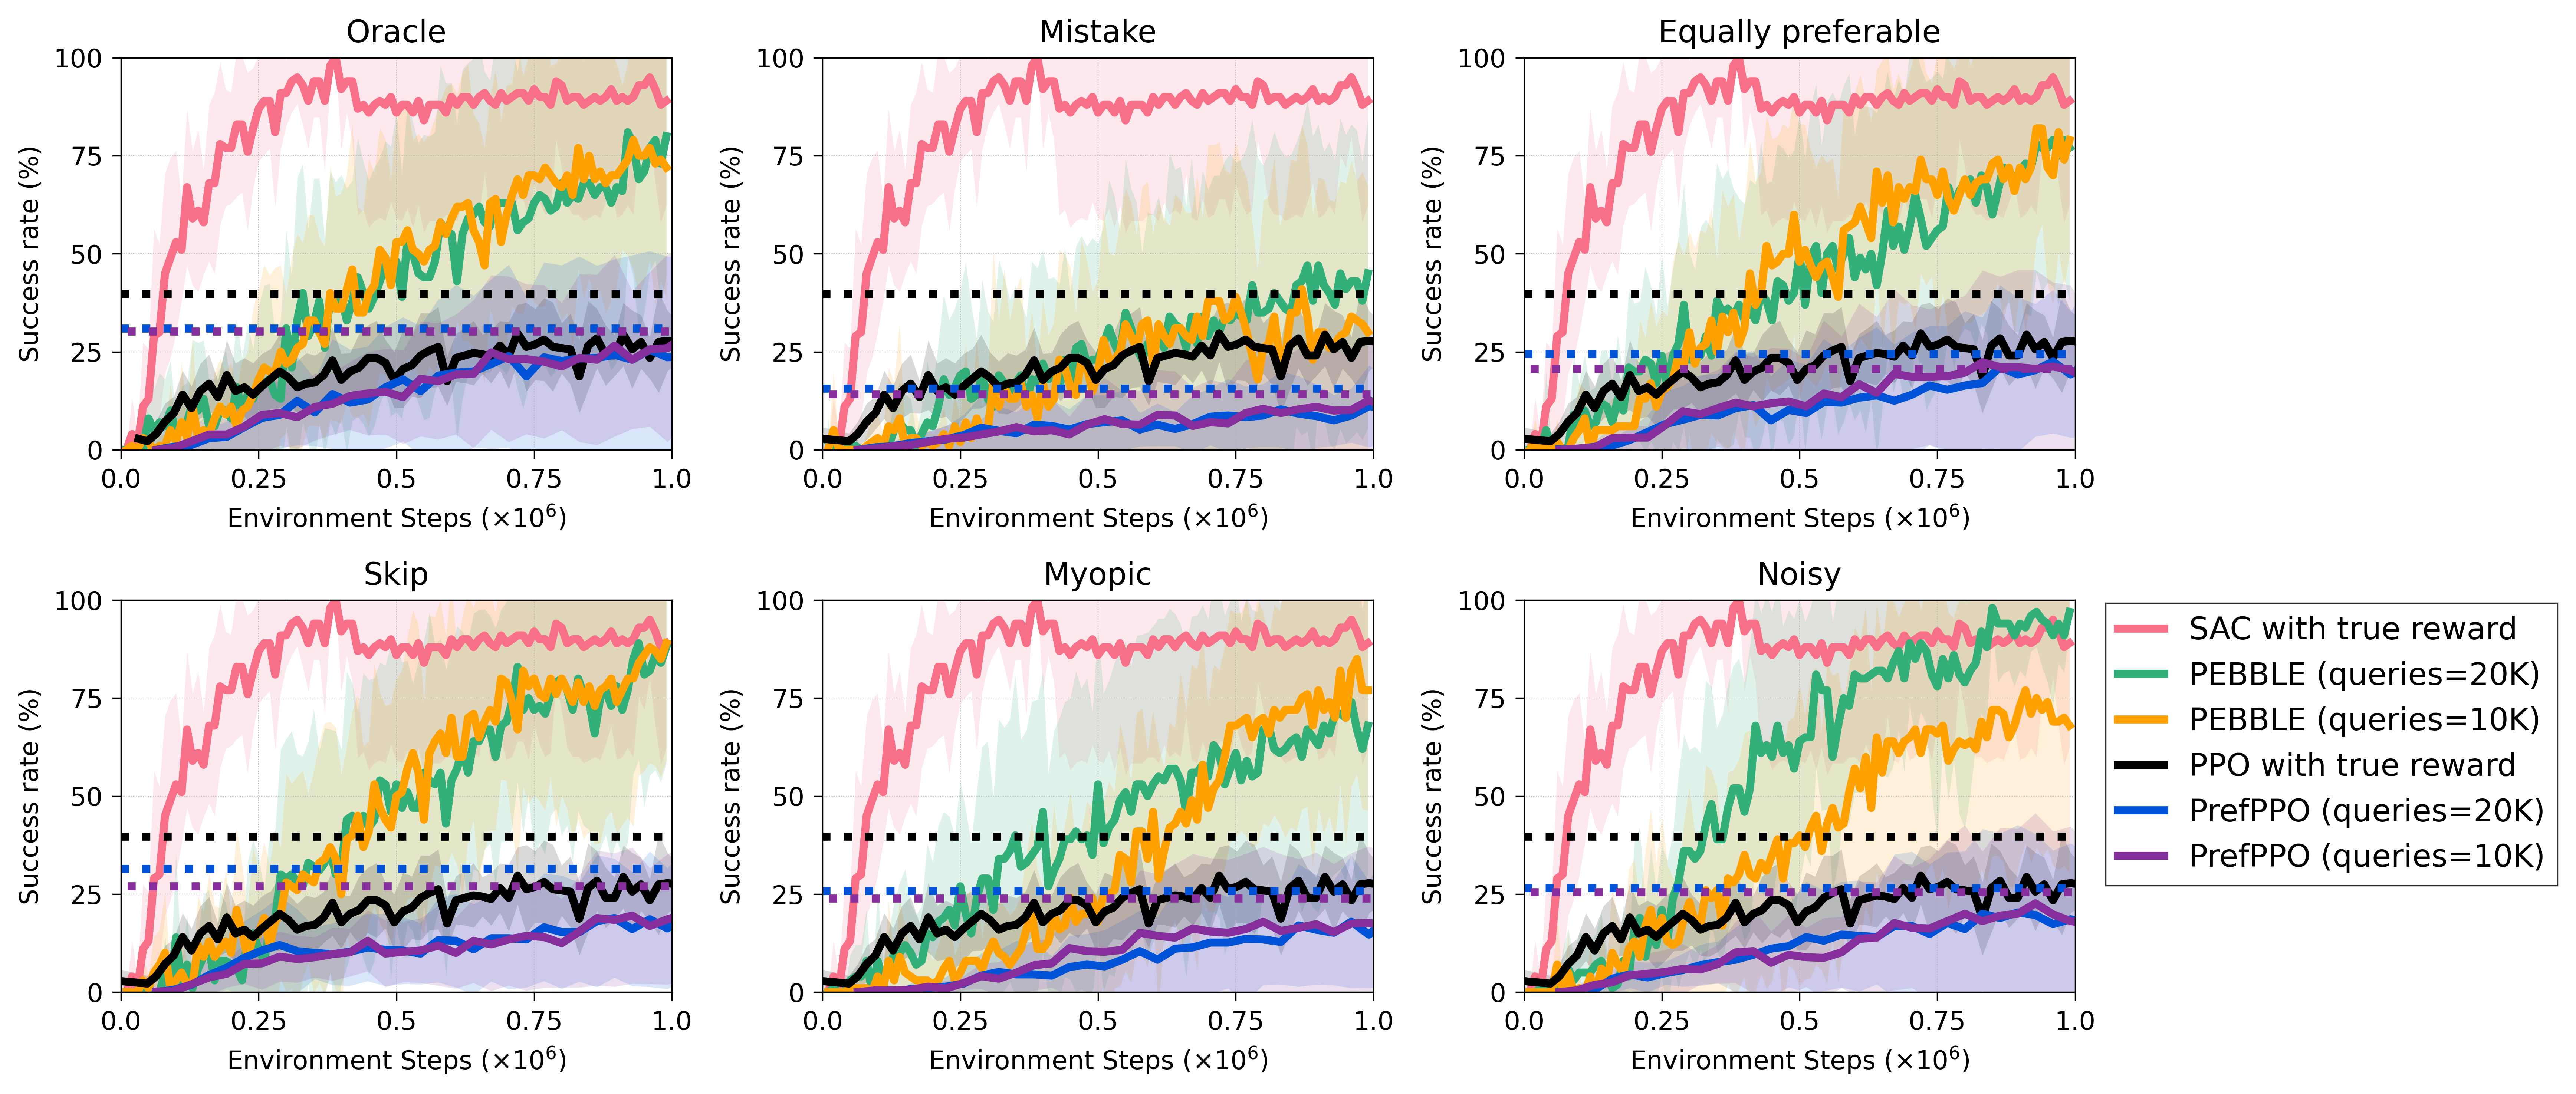

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equally preferable', 
                     'Skip', 'Myopic', 'Stoc']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
prefppo_2K_list, prefppo_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
    for name in sac_normal_name_list:
        label = name
        score = sac_normal_s_avg[name]
        std = sac_normal_s_std[name]
        steps = sac_normal_s_step[name].reshape(-1)
        ours_color = color_list[0]
        ax = draw_figures(steps/base, score, std, ax, 
                          sac_color, 'SAC with true reward') 
        sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_s_avg[name]
        std = new_pebble_s_std[name]
        steps = new_pebble_s_step[name].reshape(-1)
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=100' in name:
            ours_color = color_list[3]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=20K)')
            pebble_2K_max = np.max(score[max_window:])
            
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=50' in name:
            ours_color = color_list[5]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=10K)')
            pebble_1K_max = np.max(score[max_window:])
            
    for name in ppo_normal_name_list:            
        label = name
        score = s_ppo_normal_avg[name][:-60]
        std = s_ppo_normal_std[name][:-60]
        steps = s_ppo_normal_step[name].reshape(-1)[:-60]

        ppo_color = color_list[6]
        ax = draw_figures(steps/base, score, std, ax, 
                          ppo_color, 'PPO with true reward')
        
        final_per = np.zeros(steps.shape[0])
        steps[0] = 0
        final_per[:] = np.max(score[max_window:])
        ppo_max = np.max(score[max_window:])
        ax = draw_figures(steps/base, final_per, 0, ax, 
                          ppo_color, '', dash=2)
     
    for name in un_pre_ppo_name_list:
        label = name
        score = s_un_pre_ppo_avg[name]
        std = s_un_pre_ppo_std[name]
        steps = s_un_pre_ppo_step[name].reshape(-1)

        if preppo_feed_type in name and teacher_flag in name:
            if 'max=20000' in name:
                ours_color = color_list[2]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=20K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 0
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_2K_max = np.max(score[max_window:])
            elif 'max=10000' in name:
                ours_color = new_purple_color
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=10K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 12000
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_1K_max = np.max(score[max_window:])
    
    pebble_2K_list.append(pebble_2K_max/sac_max)
    pebble_1K_list.append(pebble_1K_max/sac_max)
    unprefppo_2K_list.append(un_preppo_2K_max/ppo_max)
    unprefppo_1K_list.append(un_preppo_1K_max/ppo_max)
    
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Success rate (%)', fontsize=10)
    ax.set_title(teacher_name, fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 25, 50, 75, 100])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    
    if index_ == 5:
        leg = ax.legend(fancybox=False, fontsize=12, bbox_to_anchor=(1.05, 1),
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

print('PEBBLE (2K):')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_2K_list[index]))
print('avg: ' + str(np.average(pebble_2K_list)))

print('\nPEBBLE (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_1K_list[index]))
print('avg: ' + str(np.average(pebble_1K_list)))

print('\nPrePPO + Pre (2K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_2K_list[index]))
print('avg: ' + str(np.average(unprefppo_2K_list)))
    
print('\nPrePPO + Pre (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_1K_list[index]))
print('avg: ' + str(np.average(unprefppo_1K_list)))

PEBBLE (2K):
Oracle: 0.81
Mistake: 0.47
Equal: 0.79
Skip: 0.89
Myopic: 0.74
Stoc: 0.97
avg: 0.7783333333333333

PEBBLE (1K): 
Oracle: 0.79
Mistake: 0.34
Equal: 0.82
Skip: 0.89
Myopic: 0.85
Stoc: 0.77
avg: 0.7433333333333335

PrePPO + Pre (2K): 
Oracle: 0.6827586206896552
Mistake: 0.3448275862068966
Equal: 0.5379310344827586
Skip: 0.6931034482758621
Myopic: 0.5689655172413793
Stoc: 0.5862068965517241
avg: 0.5689655172413793

PrePPO + Pre (1K): 
Oracle: 0.6655172413793103
Mistake: 0.3137931034482759
Equal: 0.45517241379310347
Skip: 0.596551724137931
Myopic: 0.5275862068965518
Stoc: 0.5620689655172414
avg: 0.5201149425287356


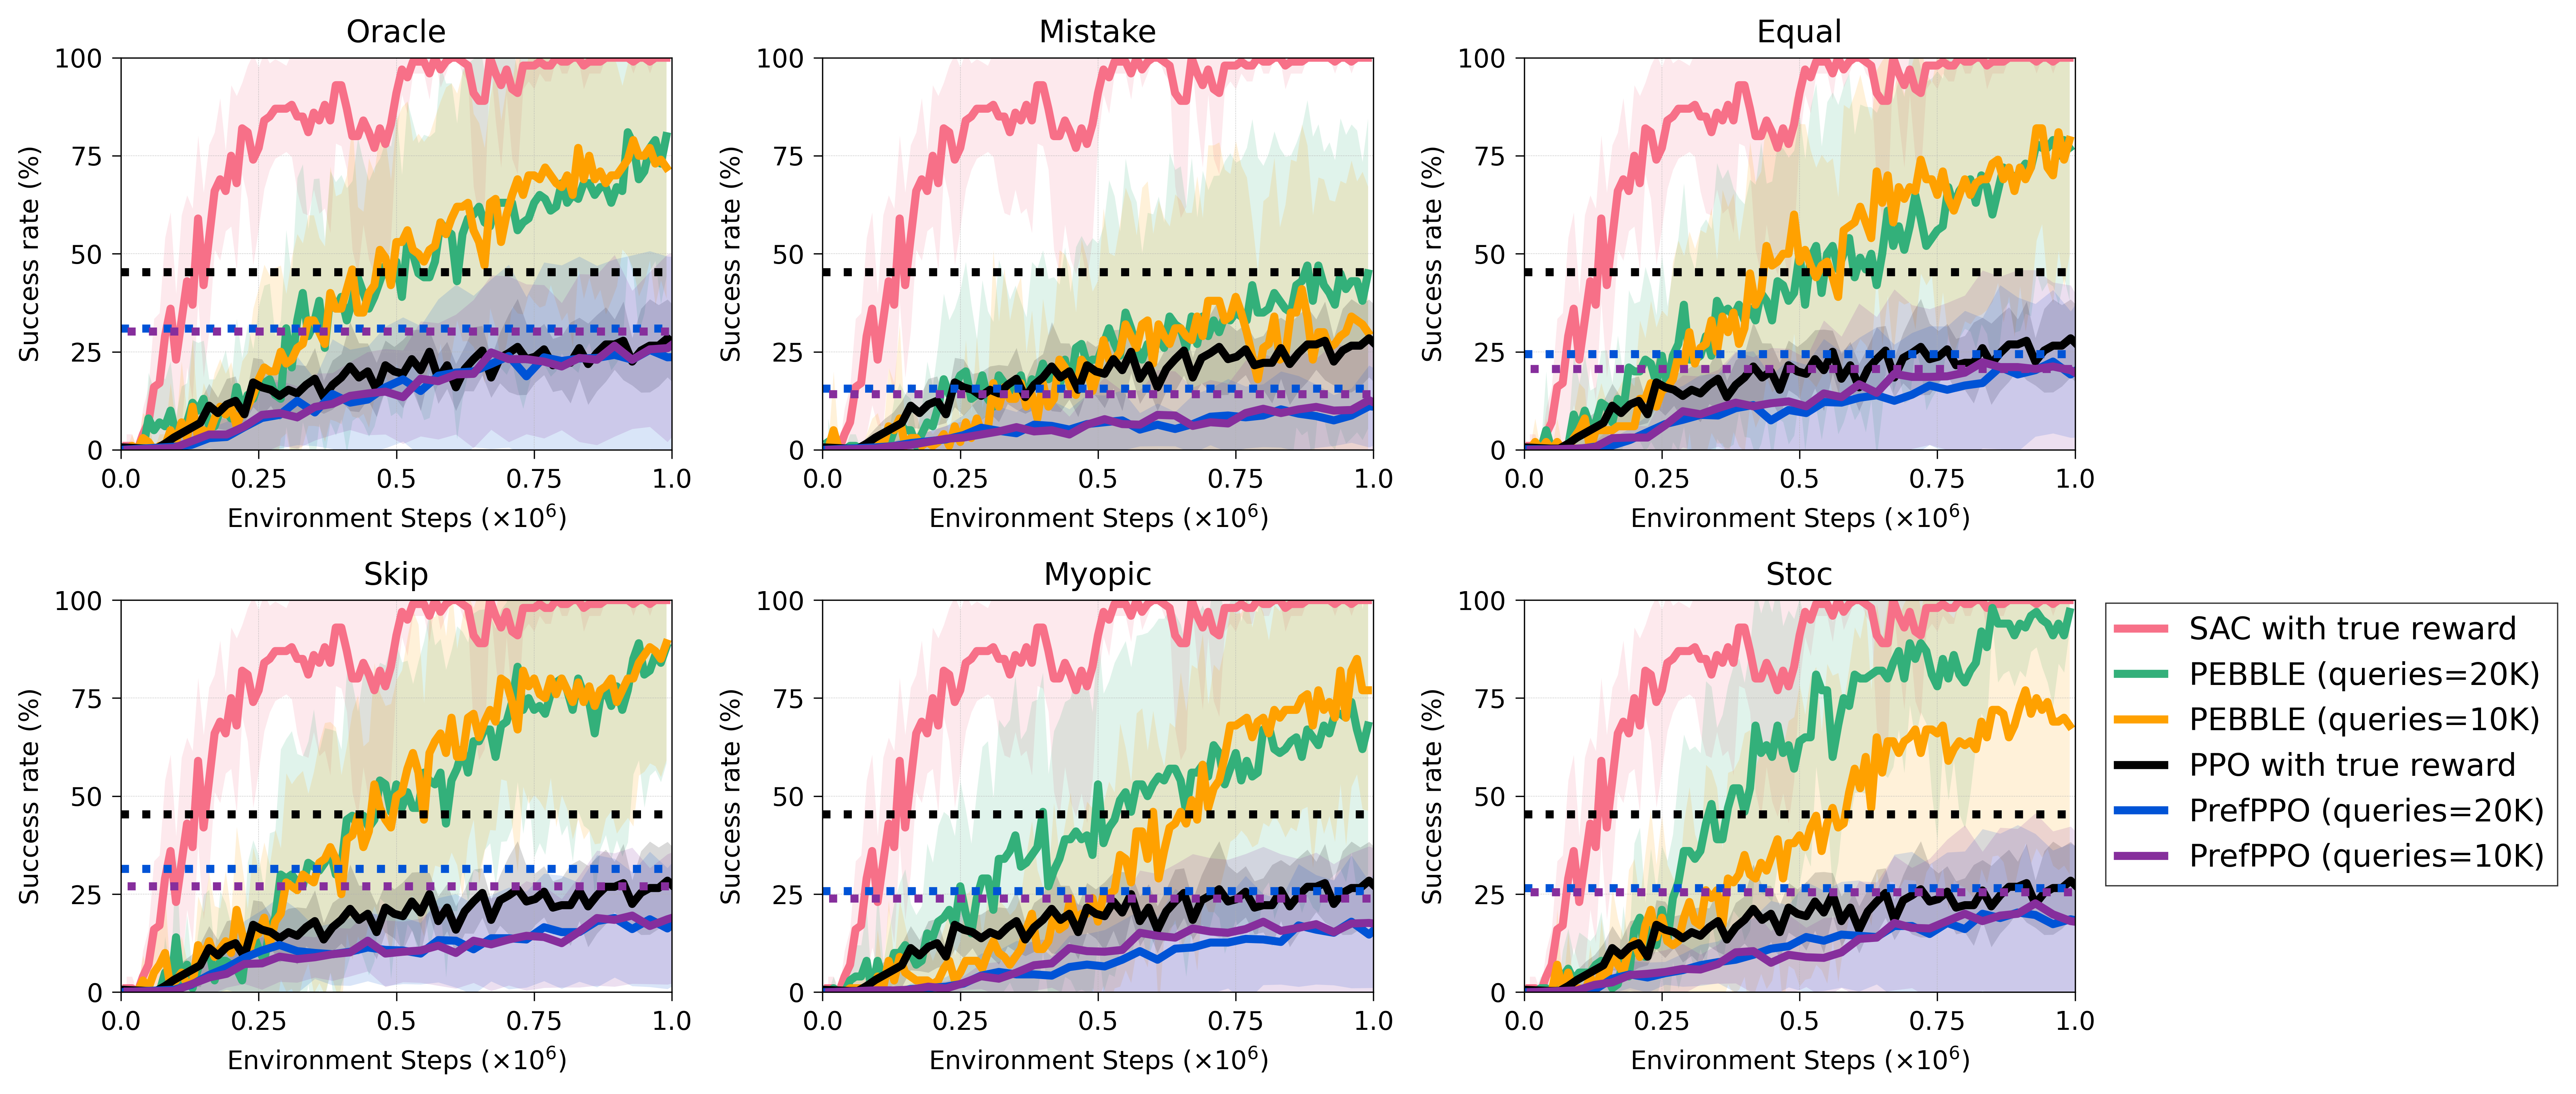

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
prefppo_2K_list, prefppo_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
    for name in sac_un_normal_name_list:
        label = name
        score = sac_un_normal_s_avg[name]
        std = sac_un_normal_s_std[name]
        steps = sac_un_normal_s_step[name].reshape(-1)
        ours_color = color_list[0]
        ax = draw_figures(steps/base, score, std, ax, 
                          sac_color, 'SAC with true reward') 
        sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_s_avg[name]
        std = new_pebble_s_std[name]
        steps = new_pebble_s_step[name].reshape(-1)
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=100' in name:
            ours_color = color_list[3]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=20K)')
            pebble_2K_max = np.max(score[max_window:])
            
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=50' in name:
            ours_color = color_list[5]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=10K)')
            pebble_1K_max = np.max(score[max_window:])
            
    for name in ppo_un_normal_name_list:            
        label = name
        score = s_ppo_un_normal_avg[name][:-60]
        std = s_ppo_un_normal_std[name][:-60]
        steps = s_ppo_un_normal_step[name].reshape(-1)[:-60]

        ppo_color = color_list[6]
        ax = draw_figures(steps/base, score, std, ax, 
                          ppo_color, 'PPO with true reward')
        
        final_per = np.zeros(steps.shape[0])
        steps[0] = 0
        final_per[:] = np.max(score[max_window:])
        ppo_max = np.max(score[max_window:])
        ax = draw_figures(steps/base, final_per, 0, ax, 
                          ppo_color, '', dash=2)
     
    for name in un_pre_ppo_name_list:
        label = name
        score = s_un_pre_ppo_avg[name]
        std = s_un_pre_ppo_std[name]
        steps = s_un_pre_ppo_step[name].reshape(-1)

        if preppo_feed_type in name and teacher_flag in name:
            if 'max=20000' in name:
                ours_color = color_list[2]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=20K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 0
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_2K_max = np.max(score[max_window:])
            elif 'max=10000' in name:
                ours_color = new_purple_color
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=10K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 12000
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_1K_max = np.max(score[max_window:])
    
    pebble_2K_list.append(pebble_2K_max/sac_max)
    pebble_1K_list.append(pebble_1K_max/sac_max)
    unprefppo_2K_list.append(un_preppo_2K_max/ppo_max)
    unprefppo_1K_list.append(un_preppo_1K_max/ppo_max)
    
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Success rate (%)', fontsize=10)
    ax.set_title(teacher_name, fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 25, 50, 75, 100])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    
    if index_ == 5:
        leg = ax.legend(fancybox=False, fontsize=12, bbox_to_anchor=(1.05, 1),
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

print('PEBBLE (2K):')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_2K_list[index]))
print('avg: ' + str(np.average(pebble_2K_list)))

print('\nPEBBLE (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_1K_list[index]))
print('avg: ' + str(np.average(pebble_1K_list)))

print('\nPrePPO + Pre (2K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_2K_list[index]))
print('avg: ' + str(np.average(unprefppo_2K_list)))
    
print('\nPrePPO + Pre (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_1K_list[index]))
print('avg: ' + str(np.average(unprefppo_1K_list)))
plt.savefig('./figure/table1_'+env_name+'.pdf')

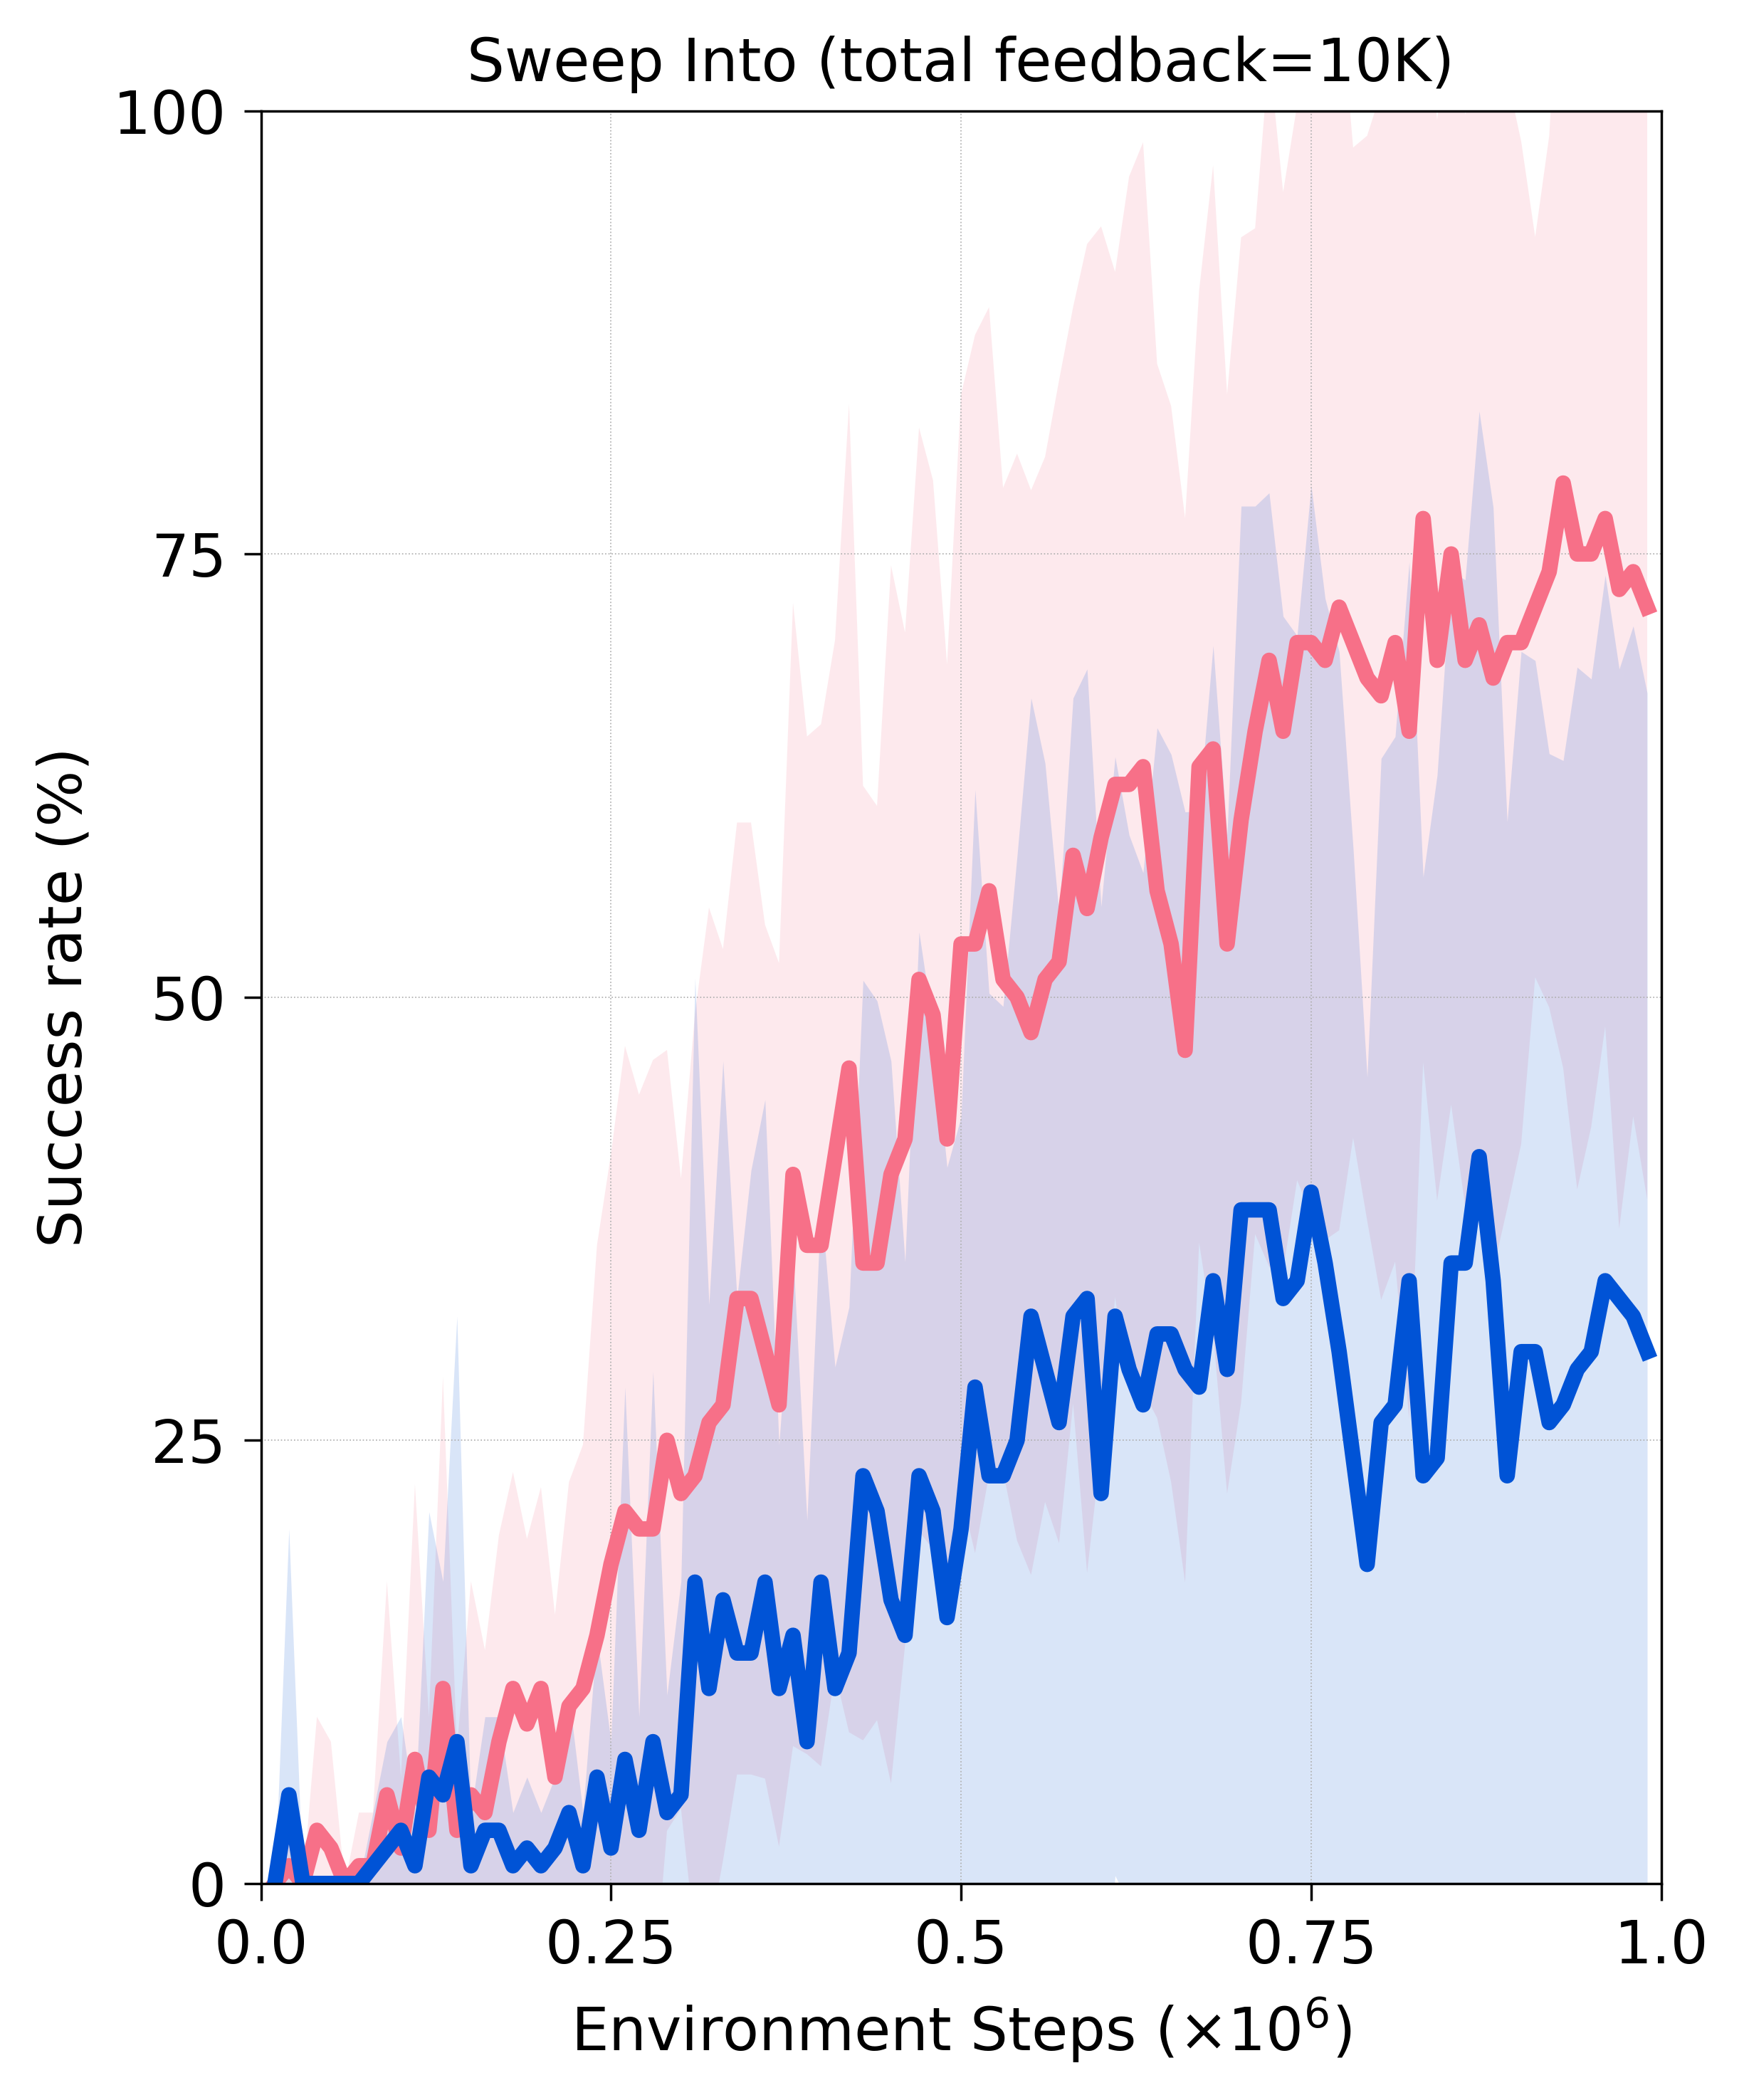

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(5, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

color_list =[red_color,  dark_blue_color,
             green_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color, red_color, blue_color, dark_blue_color,
             green_color, purple_color, new_purple_color, new_yellow_color, red_color, blue_color, dark_blue_color,
             green_color, purple_color]
color_max = len(color_list)


color_list =[red_color, dark_blue_color,
             green_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color]
color_max = len(color_list)

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Noisy']

teacher_flag_list = ['te=o', 'te=mi']
teacher_name_list = ['Oracle', 'Mistake']

# teacher_flag_list = ['te=o', 'te=e', 'te=s', ]
# teacher_name_list = ['Oracle', 'Equal', 
#                      'Skip', 'Myopic']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
prefppo_2K_list, prefppo_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
#     for name in sac_normal_name_list:
#         label = name
#         score = sac_normal_s_avg[name]
#         std = sac_normal_s_std[name]
#         steps = sac_normal_s_step[name].reshape(-1)
#         ours_color = color_list[0]
#         ax = draw_figures(steps/base, score, std, ax, 
#                           sac_color, 'SAC with true reward') 
#         sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_s_avg[name]
        std = new_pebble_s_std[name]
        steps = new_pebble_s_step[name].reshape(-1)
        for t_index in range(len(teacher_flag_list)):
            teacher_flag = teacher_flag_list[t_index]
            teacher_name = teacher_name_list[t_index]
            
            if pebble_feed_type in name and teacher_flag in name and 'num_feed=50' in name:
                ours_color = color_list[t_index]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PEBBLE on ' + teacher_name + " teacher")
                pebble_1K_max = np.max(score[max_window:])
            
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=12)
    ax.set_ylabel('Success rate (%)', fontsize=12)
    ax.set_title('Sweep Into (total feedback=10K)', fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_yticks([0, 25, 50, 75, 100])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
plt.tight_layout()

# Data generation - SAC

In [18]:
## Variables
max_window = -10
teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']
## Extract score
for name in sac_normal_name_list:
    label = name
    score = sac_normal_s_avg[name]
    sac_max = np.max(score)

for name in sac_un_normal_name_list:
    label = name
    score = sac_un_normal_s_avg[name]
    sac_un_max = np.max(score)
    
PEBBLE_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    for name in new_pebble_name_list:
        label = name
        if teacher_flag in name:
            if 'num_feed=100' in name:
                store_name = "PEBBLE (20K) (" + teacher_name + ")"
            if 'num_feed=50' in name:
                store_name = "PEBBLE (10K) (" + teacher_name + ")"
            total_score = new_pebble_s_total[name]
            sac_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_max
            sac_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_un_max
#             PEBBLE_score[store_name] = sac_norm.reshape(-1,1)
            PEBBLE_score[store_name] = sac_un_norm.reshape(-1,1)

In [19]:
for name in ppo_normal_name_list:            
    label = name
    score = s_ppo_normal_avg[name]
    ppo_max = np.max(score)
    
for name in ppo_un_normal_name_list:            
    label = name
    score = s_ppo_un_normal_avg[name]
    ppo_un_max = np.max(score)

PrefPPO_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    for name in un_pre_ppo_name_list:
        label = name
        if teacher_flag in name:
            if 'max=20000' in name:
                store_name = "PrefPPO (20K) (" + teacher_name + ")"
            elif 'max=10000' in name:
                store_name = "PrefPPO (10K) (" + teacher_name + ")"
            
            total_score = s_un_pre_ppo_tot[name]
            ppo_norm = np.mean(total_score[:,max_window:-1], axis=1) / ppo_max
            ppo_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / ppo_un_max
#             PrefPPO_score[store_name] = ppo_norm.reshape(-1,1)
            PrefPPO_score[store_name] = ppo_un_norm.reshape(-1,1)

In [20]:
save_dict(PEBBLE_score, './data/sweep_pebble.pkl')
save_dict(PrefPPO_score, './data/sweep_prefppo.pkl')